## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# 1. Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# make a list of calibration images
image_fnames = glob.glob('camera_cal/calibration*.jpg')

# load the images
images = [cv2.imread(fname) for fname in image_fnames]

In [3]:
# step through the list and search for chessboard corners

images_with_corners = list()
for image in images:
    img = image.copy() # copy to avoid reference issues
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # if found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw the corners on the original image
        img_corners = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        images_with_corners.append(img_corners)
        
print('Correctly found corners in %i images of %i' % (len(images_with_corners),len(images)))

Correctly found corners in 17 images of 20


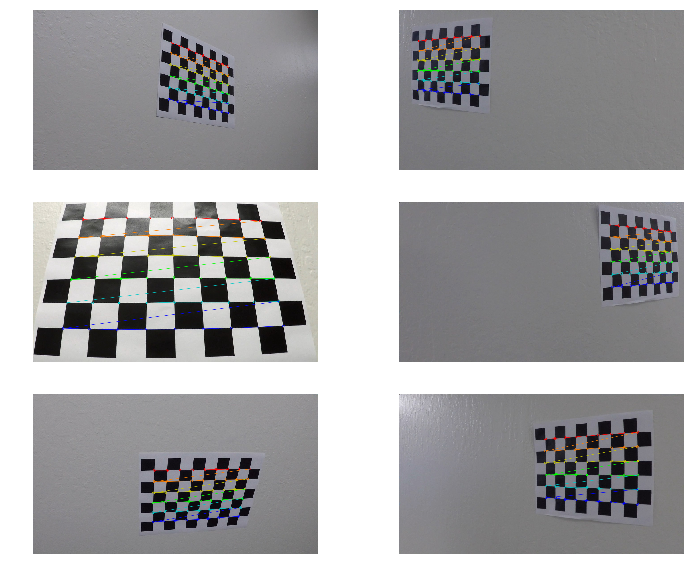

In [4]:
# plot random subset of calibration images including highlighted corners
f, axes = plt.subplots(3,2, figsize=(12,10))
axes = axes.flatten()
plot_random_subset = np.random.choice(images_with_corners, size=6, replace=False)
for i in range(plot_random_subset.shape[0]):
    axes[i].imshow(
        cv2.cvtColor(plot_random_subset[i], cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

In [5]:
# camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# encapsulate camera calibration parameters in dictionary
camera_params = {
    'ret': ret,
    'mtx': mtx,
    'dist': dist,
    'rvecs': rvecs,
    'tvecs': tvecs
}

In [6]:
# undistort the calibration images
undistorted_images = list()
for img in images:
    undistorted_images.append(cv2.undistort(img, mtx, dist, None, mtx))

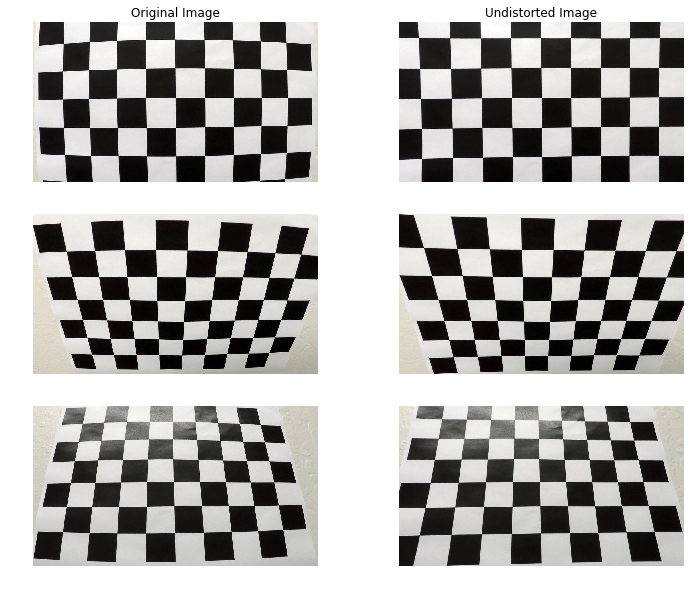

In [7]:
plot_rows = 3
plot_cols = 2
ix_list = [0, 11, 13]
f, axes = plt.subplots(plot_rows, plot_cols, figsize=(12,10))
axes = axes.flatten()
for i in range(plot_rows):
    axes[i*plot_cols].imshow(
        cv2.cvtColor(images[ix_list[i]], cv2.COLOR_BGR2RGB))
    axes[i*plot_cols].axis('off')
    axes[i*plot_cols + 1].imshow(
        cv2.cvtColor(undistorted_images[ix_list[i]], cv2.COLOR_BGR2RGB))
    axes[i*plot_cols + 1].axis('off')
    if i==0:
        axes[i].set_title('Original Image')
        axes[i + 1].set_title('Undistorted Image')

# 2. Pipeline

## 2.1 Distortion correction

In [8]:
def undistort(img, camera_params):
    mtx = camera_params['mtx']
    dist = camera_params['dist']
    return cv2.undistort(img, mtx, dist, None, mtx)

In [9]:
# load test image
test_img = cv2.imread('test_images/test3.jpg')

# undistort test image
undist_test_img = undistort(test_img, camera_params)

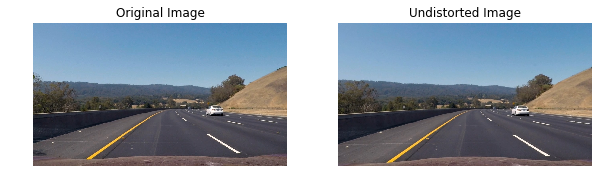

In [10]:
# plot comparison between original and undistorted images
f, axes = plt.subplots(1,2, figsize=(10,10))
axes = axes.flatten()
axes[0].imshow(
    cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(
    cv2.cvtColor(undist_test_img, cv2.COLOR_BGR2RGB)
)
axes[1].axis('off')
axes[1].set_title('Undistorted Image');

## 2.2 Thresholding

In [11]:
def plot_3_channels(img, ch_names=('Ch. 1', 'Ch. 2', 'Ch. 3')):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,10))
    ax1.imshow(
        img[:,:,0],
        cmap='gray'
    )
    ax1.axis('off')
    ax1.set_title(ch_names[0])
    ax2.imshow(
        img[:,:,1],
        cmap='gray'
    )
    ax2.set_title(ch_names[1])
    ax2.axis('off')
    ax3.imshow(
        img[:,:,2],
        cmap='gray'
    )
    ax3.axis('off')
    ax3.set_title(ch_names[2])

In [12]:
def abs_sobel_thresh(channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # take the derivative in x or y given orient = 'x' or 'y'
    orient_param = (1, 0) if orient=='x' else (0, 1)
    sobel = cv2.Sobel(channel, cv2.CV_64F, orient_param[0], orient_param[1], ksize=sobel_kernel)
    # absolute value of the derivative or gradient
    abs_sobel = np.abs(sobel)
    # scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # binary mask where thresholds are met
    binary_res = np.zeros_like(channel)
    binary_res[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_res

In [13]:
def sobel_magnitude_thresh(channel, sobel_kernel=3, thresh=(0, 255)):
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1)
    # magnitude of the gradient
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # binary mask where thresholds are met
    binary_res = np.zeros_like(channel)
    binary_res[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_res

In [14]:
def dir_threshold(channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # binary mask where thresholds are met
    binary_res = np.zeros_like(channel)
    binary_res[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_res

In [15]:
def color_channel_thresh(channel, thresh=(0, 255)):
    binary_res = np.zeros_like(channel)
    binary_res[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary_res

In [16]:
test_gray = cv2.cvtColor(undist_test_img, cv2.COLOR_BGR2GRAY)
test_hsv = cv2.cvtColor(undist_test_img, cv2.COLOR_BGR2HSV)
test_hls = cv2.cvtColor(undist_test_img, cv2.COLOR_BGR2HLS)

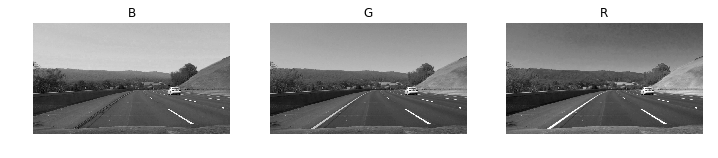

In [17]:
plot_3_channels(test_img, ('B', 'G', 'R'))

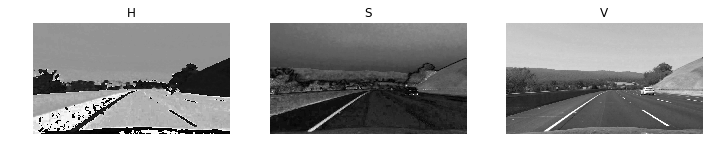

In [18]:
plot_3_channels(test_hsv, ('H', 'S', 'V'))

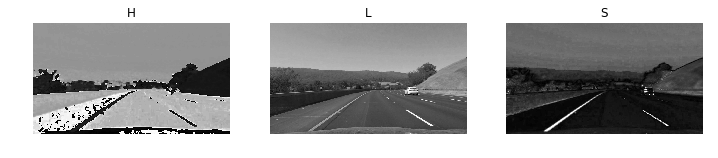

In [19]:
plot_3_channels(test_hls, ('H', 'L', 'S'))

In [20]:
h_ch, l_ch, s_ch = test_hls[:,:,0], test_hls[:,:,1], test_hls[:,:,2] 

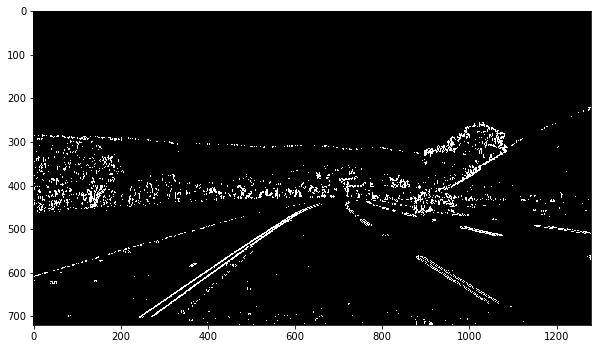

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(abs_sobel_thresh(l_ch, orient='x', sobel_kernel=5, thresh=(20, 100)), cmap='gray');

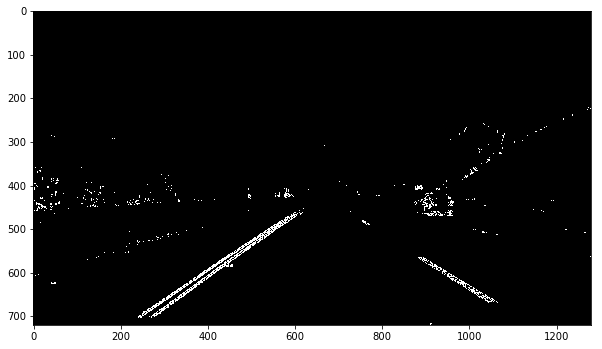

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(abs_sobel_thresh(s_ch, orient='x', sobel_kernel=3, thresh=(20, 100)), cmap='gray');

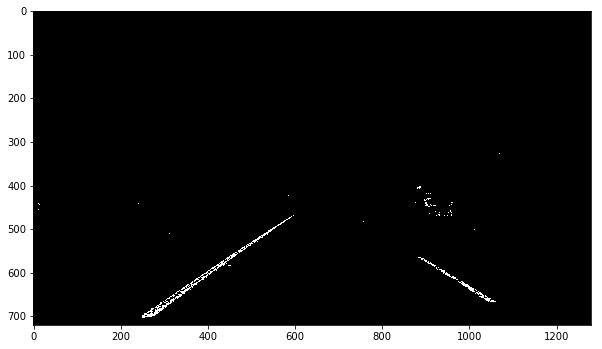

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(color_channel_thresh(s_ch, thresh=(150, 250)), cmap='gray');

In [24]:
def thresholding_pipeline(img_bgr):
    hls = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HLS)
    h_ch, l_ch, s_ch = hls[:,:,0], hls[:,:,1], hls[:,:,2] 
    
    s_sobelx_bin = abs_sobel_thresh(s_ch, orient='x', sobel_kernel=3, thresh=(20, 100))
    s_bin = color_channel_thresh(s_ch, thresh=(180, 240))
    
    bin_res = s_bin | s_sobelx_bin
    return bin_res

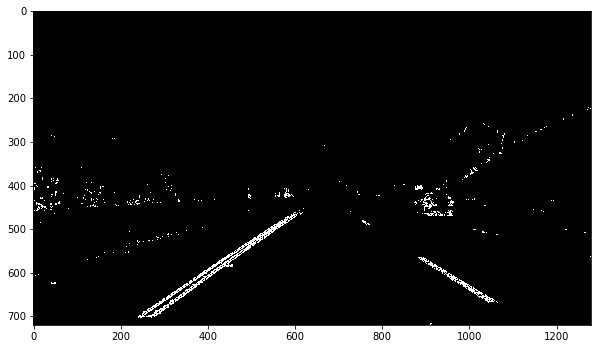

In [25]:
binary_img = thresholding_pipeline(undist_test_img)
plt.figure(figsize=(10,10))
plt.imshow(
    binary_img,
    cmap='gray'
);

## 2.3 Perspective transform

In [26]:
def warp_image(img, src, dst):

    # compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

In [27]:
def draw_polygon_on_image_inplace(img, vertices, color=[0, 0, 255], thickness=5):
    for i in range(vertices.shape[0] - 1):
        cv2.line(
            img, 
            (vertices[i][0], vertices[i][1]), 
            (vertices[i + 1][0], vertices[i + 1][1]), 
            color=color, 
            thickness=thickness
        )   

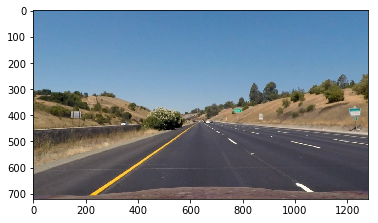

In [28]:
# load test image
warp_ref_img = cv2.imread('test_images/straight_lines1.jpg')

# undistort test image
undist_warp_ref_img = undistort(warp_ref_img, camera_params)
plt.imshow(cv2.cvtColor(undist_warp_ref_img, cv2.COLOR_BGR2RGB));

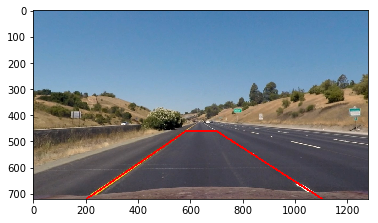

In [29]:
test_poly = np.copy(undist_warp_ref_img)
img_size = test_poly.shape[:2]
src_vertices = np.float32(
    [
        [img_size[1] / 6 - 10, img_size[0]],
        [img_size[1] / 2 - 55, img_size[0] / 2 + 100],
        [img_size[1] / 2 + 60, img_size[0] / 2 + 100],
        [img_size[1] * 5 / 6 + 40, img_size[0]]
    ]
)
draw_polygon_on_image_inplace(test_poly, src_vertices)
plt.imshow(cv2.cvtColor(test_poly, cv2.COLOR_BGR2RGB));

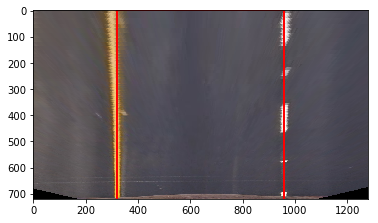

In [30]:
dst_vertices = np.float32(
    [
        [img_size[1] / 4, img_size[0]],
        [img_size[1] / 4, 0],
        [img_size[1] * 3 / 4, 0],
        [img_size[1] * 3 / 4, img_size[0]]
    ]
)
test_warped = warp_image(undist_warp_ref_img, src_vertices, dst_vertices)
draw_polygon_on_image_inplace(test_warped, dst_vertices)
plt.imshow(cv2.cvtColor(test_warped, cv2.COLOR_BGR2RGB));

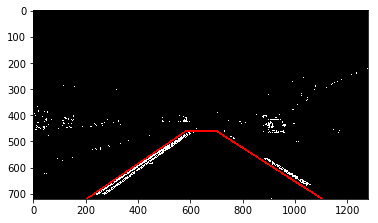

In [31]:
binary_img_copy = np.dstack((binary_img*255,)*3)
draw_polygon_on_image_inplace(binary_img_copy, src_vertices)
plt.imshow(cv2.cvtColor(binary_img_copy, cv2.COLOR_BGR2RGB));

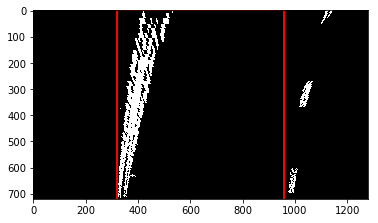

In [32]:
warped_binary_img = warp_image(binary_img, src_vertices, dst_vertices)
warped_binary_img_copy = np.dstack((warped_binary_img*255,)*3)
draw_polygon_on_image_inplace(warped_binary_img_copy, dst_vertices)
plt.imshow(cv2.cvtColor(warped_binary_img_copy, cv2.COLOR_BGR2RGB));

## 2.4 Lane detection

In [33]:
binary_warped = np.copy(warped_binary_img)

In [34]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

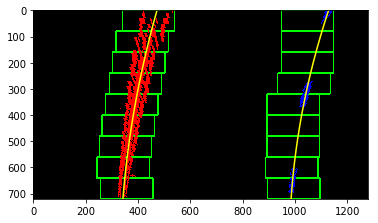

In [35]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0);

In [36]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

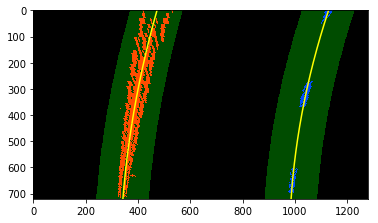

In [37]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped,)*3)*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0);

In [38]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

3557.98644081 2762.38151642


In [39]:
def calculate_radius_in_meters(y_eval, fit_coeffs, x_meters_per_px=3.7/700, y_meters_per_px=30/720):
    alpha = (x_meters_per_px / y_meters_per_px)**2
    beta = x_meters_per_px / (y_meters_per_px**2)
    a, b = fit_coeffs[0], fit_coeffs[1]
    r = 1/beta*((1 + alpha*(2*a*y_eval + b)**2)**1.5) / np.absolute(2*a)
    return r

In [40]:
calculate_radius_in_meters(y_eval, left_fit, 3.7/700, 30/720)

1157.9801127636558